In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
import peaks_utility as psu
import s2_selection_utility as ssu
from multihist import Hist1d, Histdd
import time
import itertools
import os
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

Start import
Working on midway2-0411.rcc.local with the following versions 
and installation paths:
strax
	v0.12.4	/dali/lgrandi/strax/strax/strax
straxen
	v0.12.3	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [7]:
run_id = '009746'
events = st.get_array(run_id,'event_basics')
peaks = st.get_array(run_id,'peak_basics')
s2_times = events['s2_time']
s2_endtimes = events['s2_endtime']

In [7]:
ndiv = 10
start = [0, 4574, 9069, 13611, 18127, 22632, 27178, 31688, 36148, 40709, 45191]

run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 9, tot. events 198587, selected 4482, tot.sel. 45191 time to process 7.11 s
[0, 4574, 9069, 13611, 18127, 22632, 27178, 31688, 36148, 40709, 45191]


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


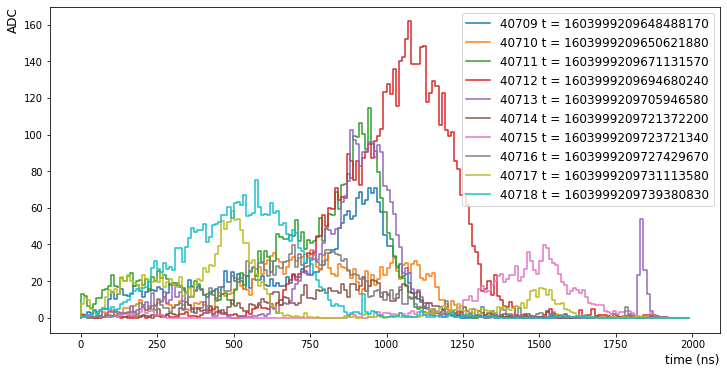

In [16]:
for div in range(9,10):
    pdata, start[div+1] = ssu.select_peaks_times(st, run_id, peaks, s2_times, ndiv, div, int(start[div]))
print(start)
#psu.plot_area_width(pdata)

In [8]:
PMTs = [93, 188, 206]
ndiv = 10
for div in range(9,ndiv):
    filename = f'data/select_peaks_run{run_id}_div{div}.h5'
    pdata = pd.read_hdf(filename)
    areas = np.array(pdata['area'])
    widths = np.array(pdata['range_50p_area'])
    area_chn = np.array(pdata['area_per_channel'])
    rdata = ssu.select_records_times(st,run_id,peaks,s2_times,s2_endtimes,areas,area_chn,widths,PMTs,ndiv,div,int(start[div]))

run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 9, tot. events 7504406, selected events: 65719 45192, time to process: 20.86 s


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['data'], dtype='object')]

  encoding=encoding,


In [4]:
PMTs = [93, 188, 206]
mdata = ssu.merge_records(run_id, PMTs, ndiv = 10)

Reading: ./data/select_records_run009746_div0.h5, initial records: 66090, events: 4573
0, time to process: 1.99


/home/valerioda/xenon-notes/fast_response_analysis/s2_selection_utility.py:214: RuntimeWarning: invalid value encountered in double_scalars
  rec_x /= area_sum
/home/valerioda/xenon-notes/fast_response_analysis/s2_selection_utility.py:215: RuntimeWarning: invalid value encountered in double_scalars
  rec_y /= area_sum


1000, time to process: 21.77
2000, time to process: 41.92
3000, time to process: 61.90
4000, time to process: 82.32
Merged records 13685
Reading: ./data/select_records_run009746_div1.h5, initial records: 65143, events: 4494
4574, time to process: 94.02
5000, time to process: 102.25
6000, time to process: 122.78
7000, time to process: 142.85
8000, time to process: 162.76
9000, time to process: 182.47
Merged records 27135
Reading: ./data/select_records_run009746_div2.h5, initial records: 66782, events: 4541
9069, time to process: 184.96
10000, time to process: 203.50
11000, time to process: 223.70
12000, time to process: 243.82
13000, time to process: 263.69
Merged records 40734
Reading: ./data/select_records_run009746_div3.h5, initial records: 64547, events: 4515
13611, time to process: 276.15
14000, time to process: 283.96
15000, time to process: 303.26
16000, time to process: 323.24
17000, time to process: 342.69
18000, time to process: 362.14
Merged records 54242
Reading: ./data/sele

/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['data'], dtype='object')]

  encoding=encoding,


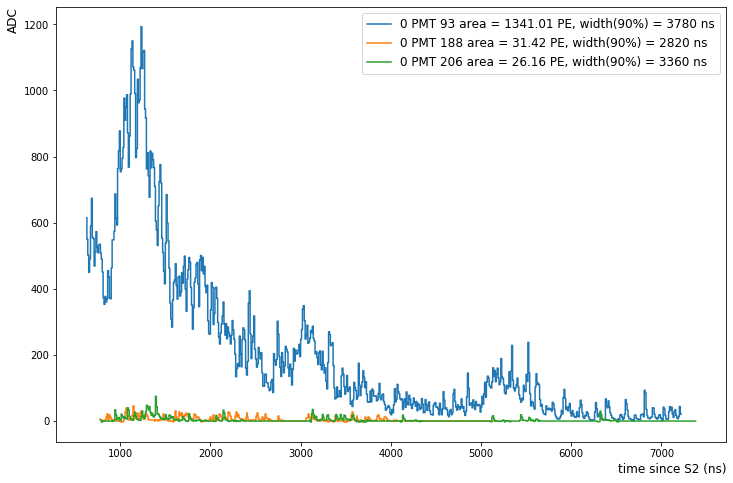

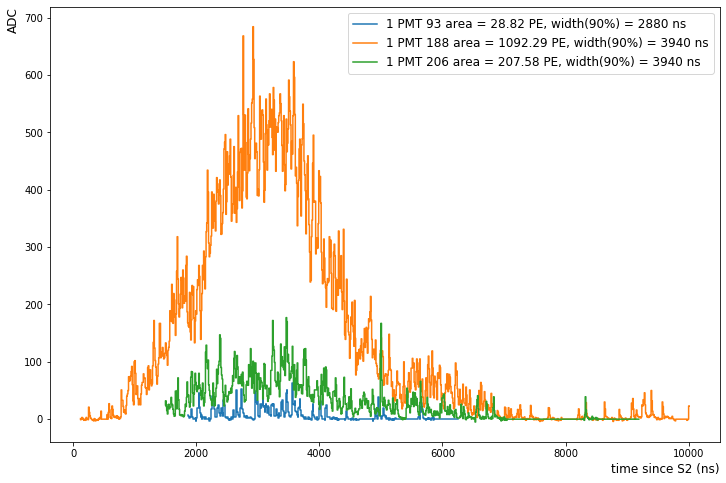

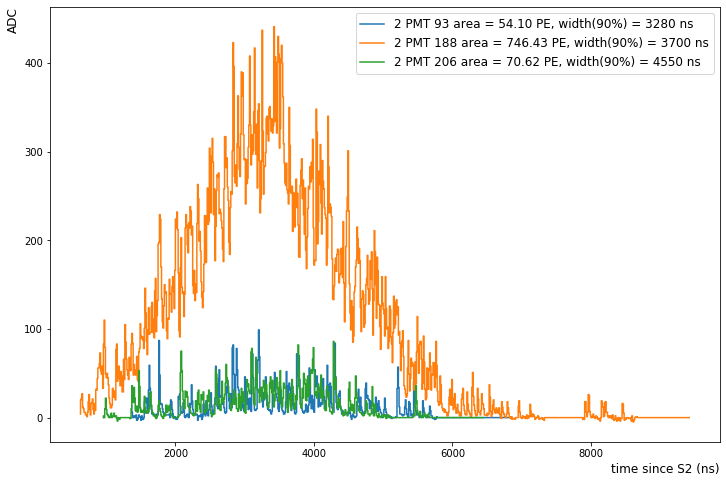

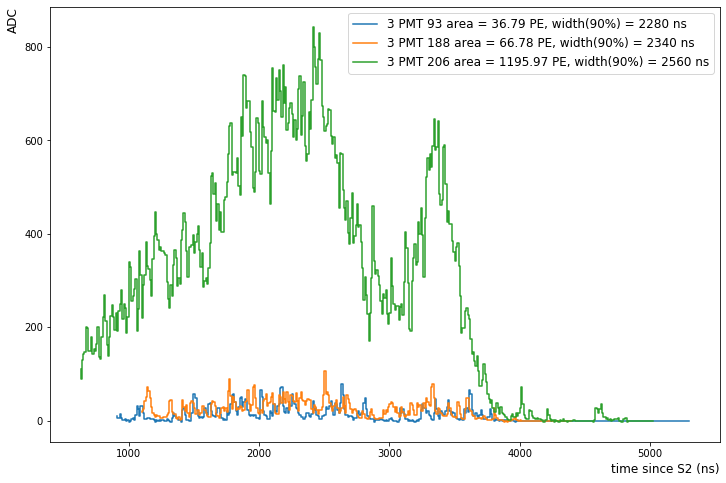

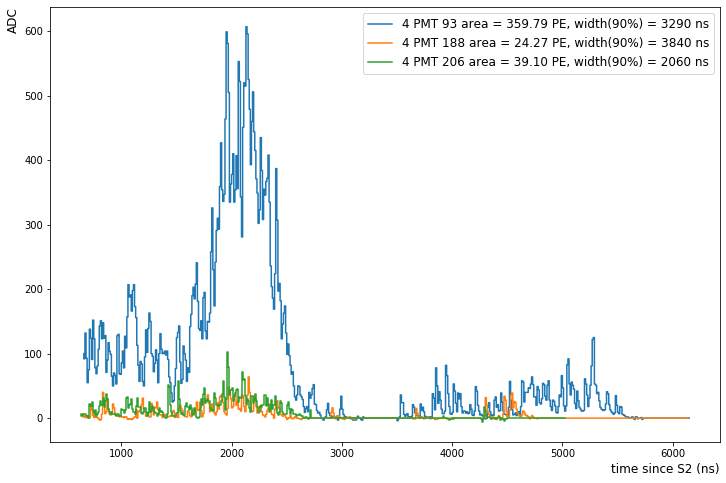

In [4]:
PMTs = [93, 188, 206]
mdata = pd.read_hdf(f'data/merged_records_run{run_id}.h5')
for k in range(5):
    plt.figure(k,figsize=(12,8))
    for i, PMT in enumerate(PMTs):
        rr = mdata[(mdata['event_number']==k) & (mdata['channel']==PMT)]
        idx = rr.first_valid_index()
        if idx is None: break
        tt = rr['time'][idx] - rr['event_time'][idx]
        wf = mdata['data'][idx]
        dt = mdata['dt'][idx]
        area = mdata['area_per_channel'][idx]
        width = mdata['width90'][idx]
        dts = np.arange(tt,len(wf)*dt+tt,dt)
        plt.plot( dts, wf, drawstyle='steps', color=colors[i],
                 label=f'{k} PMT {PMT} area = {area:.2f} PE, width(90%) = {width} ns')
        #plt.axvline(x=tt+wftot.argmax()*rr['dt'][idx],color=colors[i],linestyle='-')
        #plt.axvline(x=tt+ilo*rr['dt'][idx],color=colors[i],linestyle='--')
        #plt.axvline(x=tt+ihi*rr['dt'][idx],color=colors[i],linestyle='--')
        plt.xlabel("time since S2 (ns)", ha='right', x=1,fontsize=12)
        plt.ylabel(f"ADC", ha='right', y=1,fontsize=12)
        plt.legend(fontsize=12)

PMT 93 events 45135
PMT 188 events 45094
PMT 206 events 45028


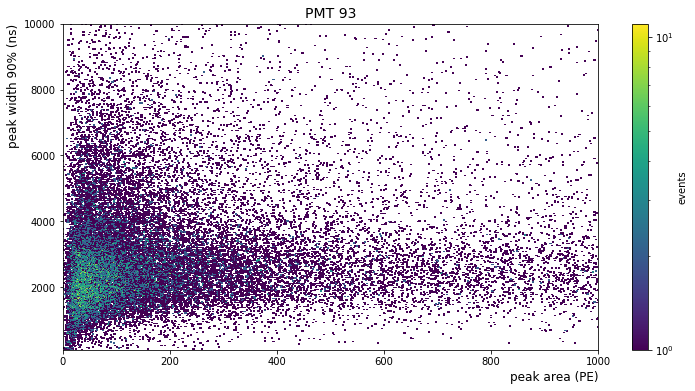

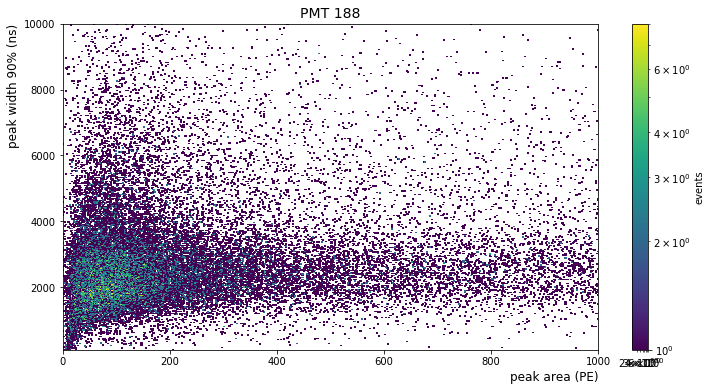

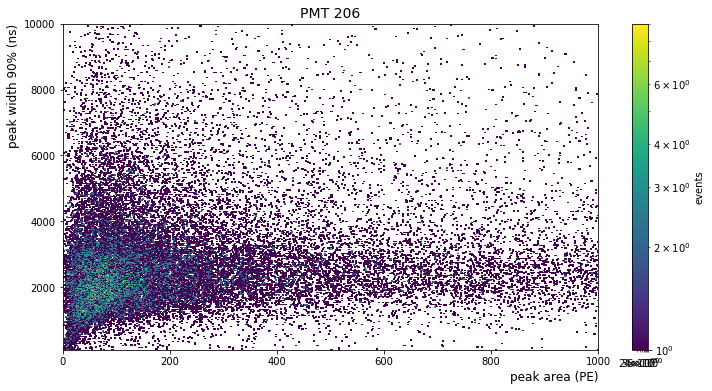

In [29]:
for PMT in PMTs:
    mdata1 = mdata[mdata['channel']==PMT]
    print('PMT',PMT,'events',len(mdata1))
    ph50 = Histdd(mdata1['area_per_channel'], mdata1['width90'],
                  bins=(np.linspace(0, 1000, 500), np.linspace(100, 10000, 500)))
    plt.figure(figsize=(12,6))
    ph50.plot(log_scale=True, cblabel='events')
    plt.xlabel("peak area (PE)", ha='right', x=1,fontsize=12)
    plt.ylabel("peak width 90% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'PMT {PMT}',fontsize=14)
    #plt.xscale('log')
    #plt.yscale('log')

PMT 93 events 41783
PMT 188 events 41753
PMT 206 events 41714


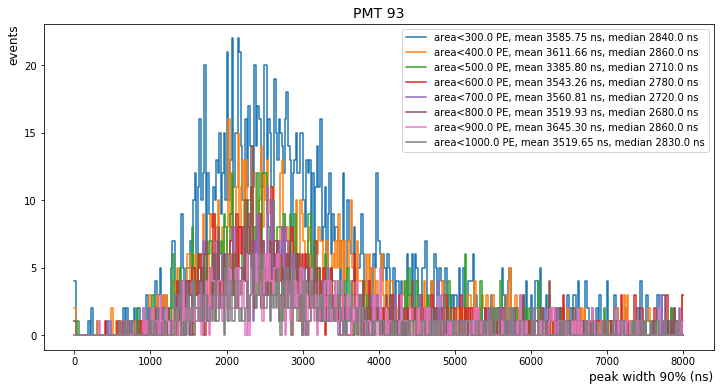

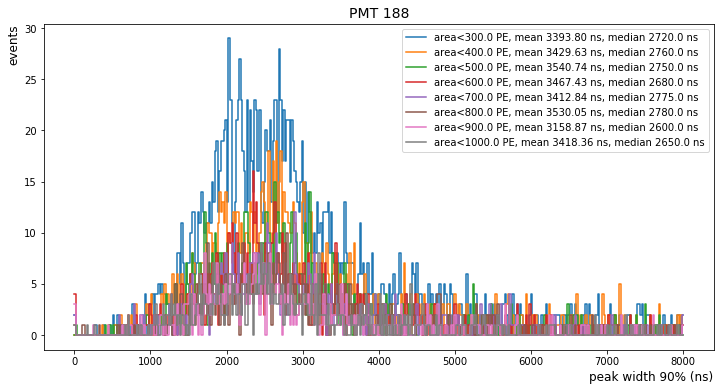

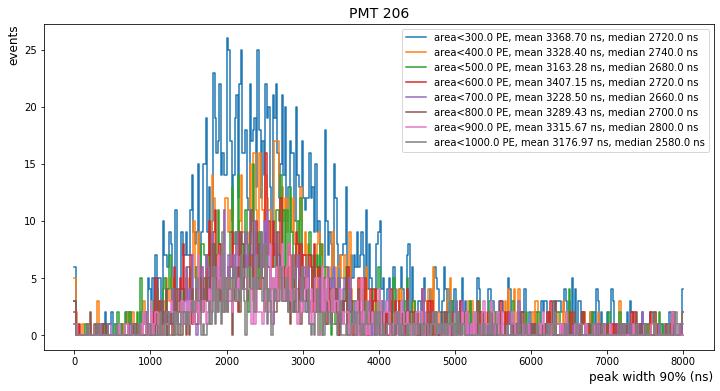

In [7]:
media = np.zeros((len(PMTs),10))
stand = np.zeros((len(PMTs),10))
median = np.zeros((len(PMTs),10))
arear = np.zeros((len(PMTs),10))
for i, PMT in enumerate(PMTs):
    mdata1 = mdata[(mdata['channel']==PMT)]
    print('PMT',PMT,'events',len(mdata1))
    maxp = 8000
    binn= int(maxp/20)
    plt.figure(figsize=(12,6))
    for ii in range(2,10):
        alo, ahi = 1e2*ii, 1e2*(ii+1)
        mdata2 = mdata1[(mdata1['area_per_channel']>alo)&(mdata1['area_per_channel']<ahi)]
        media[i][ii] = mdata2['width90'].mean()
        stand[i][ii] = mdata2['width90'].std()
        median[i][ii] = mdata2['width90'].median()
        arear[i][ii] = ahi
        #print(PMT,ii,width,median,)
        ph = Hist1d(mdata2['width90'],bins=(np.linspace(0, maxp, binn)))
        ph.plot(label=f'area<{ahi} PE, mean {media[i][ii]:.2f} ns, median {median[i][ii]} ns')
        #plt.axvline(x=width,color=colors[ii],linestyle='-')
        #plt.axvline(x=median,color=colors[ii],linestyle='--')
        plt.ylabel("events", ha='right', y=1,fontsize=12)
        plt.xlabel("peak width 90% (ns)", ha='right', x=1,fontsize=12)
        plt.title(f'PMT {PMT}',fontsize=14)
        plt.legend()

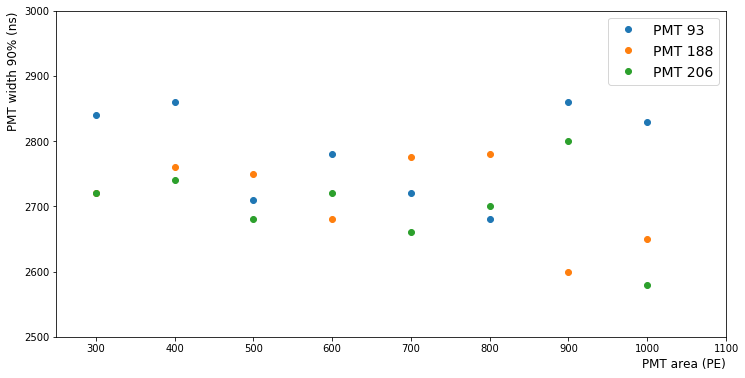

In [8]:
plt.figure(figsize=(12,6))
for i, PMT in enumerate(PMTs):
    plt.plot(arear[i],median[i],'o',label=f'PMT {PMT}')
    plt.xlabel("PMT area (PE)", ha='right', x=1,fontsize=12)
    plt.ylabel("PMT width 90% (ns)", ha='right', y=1,fontsize=12)
    plt.xlim(250,1100)
    plt.ylim(2500,3000)
    plt.legend(fontsize=14)

In [8]:
PMTs = [93, 188, 206]
mdata = pd.read_hdf(f'data/merged_records_run{run_id}.h5')

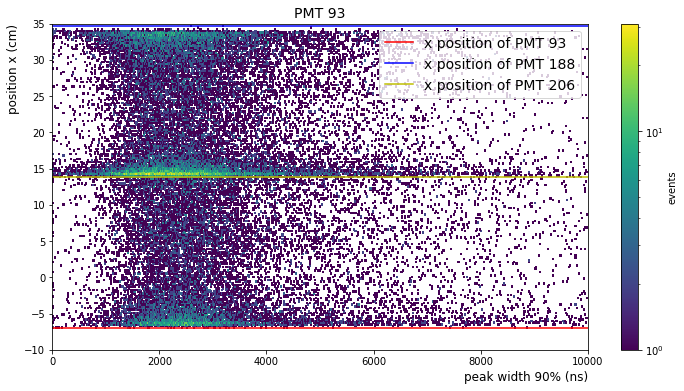

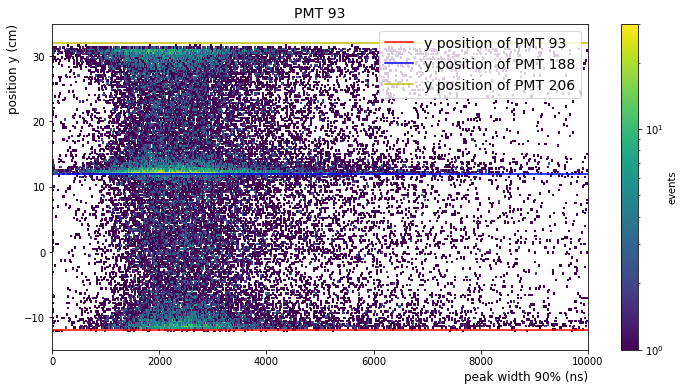

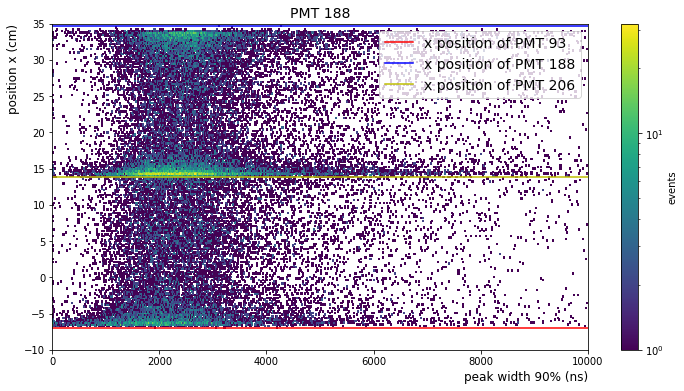

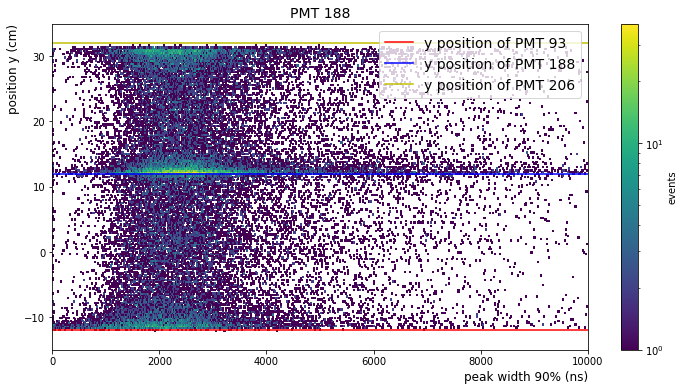

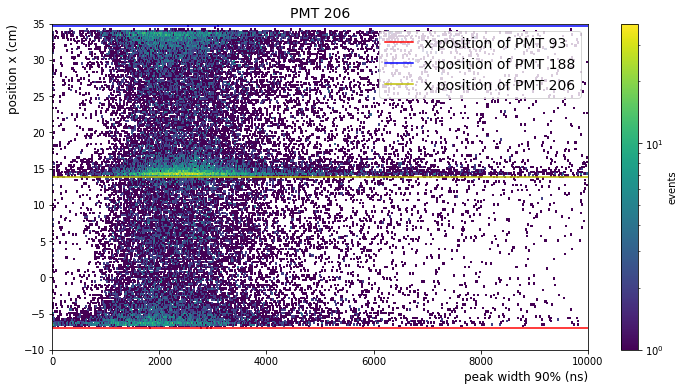

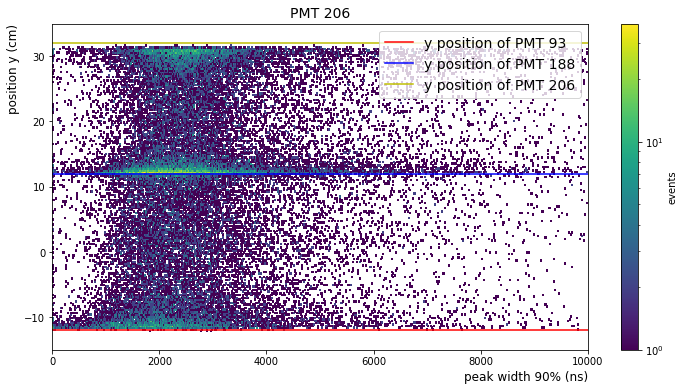

In [14]:
positions = straxen.pmt_positions()
for i, PMT in enumerate(PMTs):
    mdata1 = mdata[mdata['channel']==PMT]
    pos_x0 = np.float(positions['x'][positions['i']==PMTs[0]])
    pos_y0 = np.float(positions['y'][positions['i']==PMTs[0]])
    pos_x1 = np.float(positions['x'][positions['i']==PMTs[1]])
    pos_y1 = np.float(positions['y'][positions['i']==PMTs[1]])
    pos_x2 = np.float(positions['x'][positions['i']==PMTs[2]])
    pos_y2 = np.float(positions['y'][positions['i']==PMTs[2]])
    plt.figure(figsize=(12,6))
    ph50x = Histdd(mdata1['width90'], mdata1['position_x'],
                  bins=(np.linspace(0, 10000, 500), np.linspace(-10, 35, 200)))
    ph50x.plot(log_scale=True, cblabel='events')
    plt.axhline(pos_x0,color='r',label=f'x position of PMT {PMTs[0]}')
    plt.axhline(pos_x1,color='b',label=f'x position of PMT {PMTs[1]}')
    plt.axhline(pos_x2,color='y',label=f'x position of PMT {PMTs[2]}')
    plt.xlabel("peak width 90% (ns)", ha='right', x=1,fontsize=12)
    plt.ylabel("position x (cm)", ha='right', y=1,fontsize=12)
    plt.title(f'PMT {PMT}',fontsize=14)
    plt.legend(fontsize=14,loc='upper right')
    
    ph50y = Histdd(mdata1['width90'], mdata1['position_y'],
                  bins=(np.linspace(0, 10000, 500), np.linspace(-15, 35, 200)))
    plt.figure(figsize=(12,6))
    ph50y.plot(log_scale=True, cblabel='events')
    plt.axhline(pos_y0,color='r',label=f'y position of PMT {PMTs[0]}')
    plt.axhline(pos_y1,color='b',label=f'y position of PMT {PMTs[1]}')
    plt.axhline(pos_y2,color='y',label=f'y position of PMT {PMTs[2]}')
    plt.xlabel("peak width 90% (ns)", ha='right', x=1,fontsize=12)
    plt.ylabel("position y (cm)", ha='right', y=1,fontsize=12)
    plt.title(f'PMT {PMT}',fontsize=14)
    plt.legend(fontsize=14,loc='upper right')

PMT 93 events 6856
PMT 188 events 6994
PMT 206 events 6851


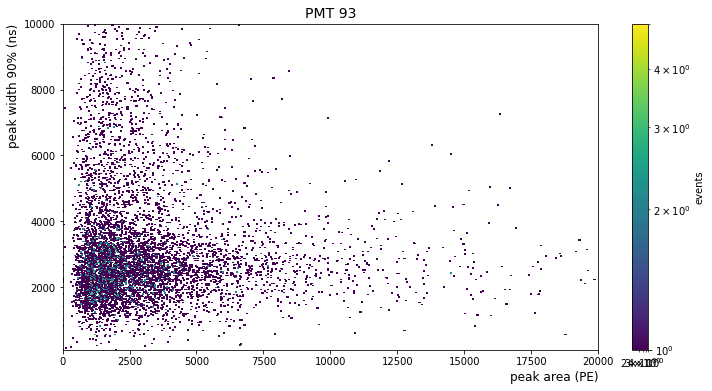

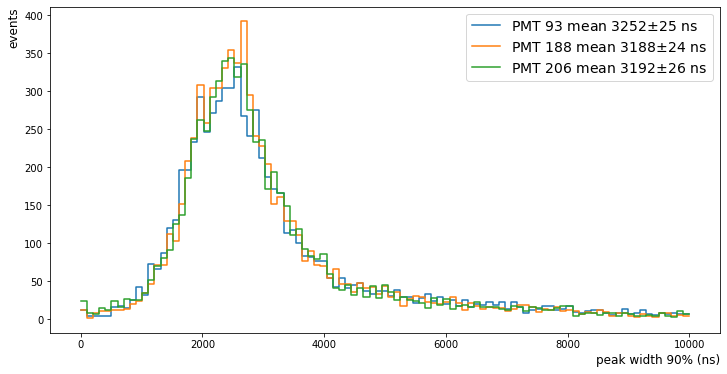

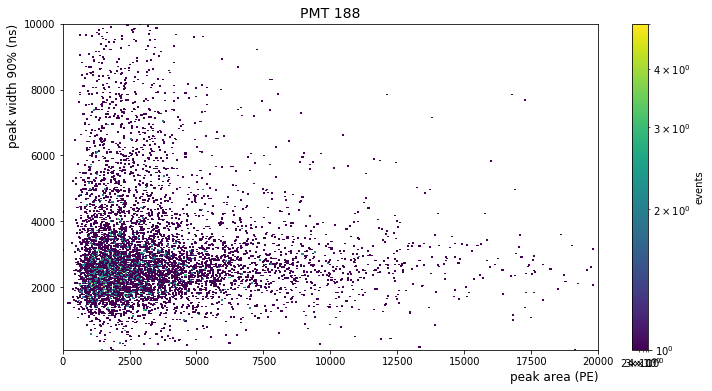

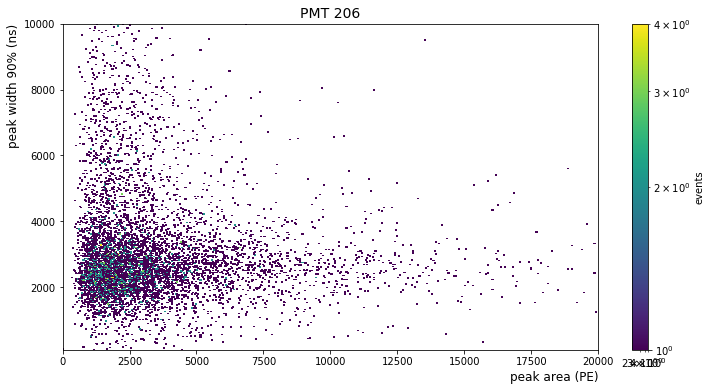

In [51]:
positions = straxen.pmt_positions()
for i, PMT in enumerate(PMTs):
    pos_x = np.float(positions['x'][positions['i']==PMT])
    pos_y = np.float(positions['y'][positions['i']==PMT])
    dist = 4
    mdata1 = mdata[(mdata['channel']==PMT) &
                   (mdata['position_x']<pos_x+dist) & (mdata['position_x']>pos_x-dist) &
                   (mdata['position_y']<pos_y+dist) & (mdata['position_y']>pos_y-dist)]
    print('PMT',PMT,'events',len(mdata1))
    ph50 = Histdd(mdata1['area_per_channel'], mdata1['width90'],
                  bins=(np.linspace(0, 20000, 500), np.linspace(100, 10000, 500)))
    plt.figure(i+1,figsize=(12,6))
    ph50.plot(log_scale=True, cblabel='events')
    plt.xlabel("peak area (PE)", ha='right', x=1,fontsize=12)
    plt.ylabel("peak width 90% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'PMT {PMT}',fontsize=14)
    plt.figure(0,figsize=(12,6))
    ph = Hist1d(mdata1['width90'],bins=(np.linspace(0, 10000, 100)))
    media = mdata1['width90'].mean()
    stand = mdata1['width90'].std()/np.sqrt(len(mdata1))
    median = mdata1['width90'].median()
    ph.plot(label=f'PMT {PMT} mean {media:.0f}$\pm${stand:.0f} ns')
    #plt.axvline(x=width,color=colors[ii],linestyle='-')
    #plt.axvline(x=median,color=colors[ii],linestyle='--')
    plt.ylabel("events", ha='right', y=1,fontsize=12)
    plt.xlabel("peak width 90% (ns)", ha='right', x=1,fontsize=12)
    #plt.title(f'PMT {PMT}',fontsize=14)
    plt.legend(fontsize=14)